### Training

In [ ]:
!pip uninstall torchcodec

In [ ]:
!pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.6/221.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.3/377.3 kB 29.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.12.0
    Uninstalling fsspec-2025.12.0:
      Successfully uninstalled fsspec-2025.12.0


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import load_dataset
import torchaudio.transforms as T

# --- 1. CONFIGURATION ---
SR = 22050                # target sample rate
WIN_SIZE = 512           # Hann window size
HOP_SIZE = 128           # hop length
FFT_SIZE = 1024          # FFT length
N_MELS = 128             # mel bins
FMIN = 50                # min frequency
FMAX = SR // 2           # max frequency (11.025 kHz)
WINDOW_SEC = 3.0         # window length in seconds
STRIDE_SEC = 2.0         # stride (overlap) - Changed to 2.0 for 5s->2x3s example
TARGET_IMG_SIZE = (224, 224)  # final image size

#Batch size, Num epochs, Learning rate
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4

# Number of classes for ESC-50 dataset
NUM_CLASSES = 50


# --- 3. DATA LOAD & SPLIT ---
print("Loading ESC-50...")

# ESC-50 only has a "train" split in HF, but contains a 'fold' column (1-5)
full_dataset = load_dataset("ashraq/esc50", split="train")

# SPLIT STRATEGY: Train on Folds 1-4, Validate on Fold 5
train_data = full_dataset.filter(lambda x: x['fold'] != 5)
valid_data = full_dataset.filter(lambda x: x['fold'] == 5)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(valid_data)}")

Loading ESC-50...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/345 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00002-2f1ab7b824ec75(…):   0%|          | 0.00/387M [00:00<?, ?B/s]

data/train-00001-of-00002-27425e5c1846b4(…):   0%|          | 0.00/387M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Training samples: 1600
Validation samples: 400


### Test

In [ ]:
!pip install opencv-python

In [ ]:
import numpy as np
mean = 0.4865824173198487
std =  0.1773556497486759

print(f"Mean: {mean}, Std: {std}")
MEAN=np.stack([mean]*3)
STD=np.stack([std]*3)

Mean: 0.4865824173198487, Std: 0.1773556497486759


In [ ]:
import torchaudio
from torchvision.transforms import v2
import torch
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image
from typing import BinaryIO
import cv2
import random

# --- 3. PREPROCESSING (Audio -> Spectrogram) ---

# Define mel_transform globally here, using the correct global variables
mel_transform = T.MelSpectrogram(
    sample_rate=SR,
    n_mels=N_MELS,
    n_fft=FFT_SIZE,
    hop_length=HOP_SIZE
)

def generate_spectogram(audio_tensor: torch.Tensor, stack: bool = False) -> np.ndarray:
    # Spectrogram transform
    spectrogram = mel_transform(audio_tensor)

    # Spectrogram in dB
    spectrogram_db = torchaudio.transforms.AmplitudeToDB()(spectrogram)

    # Mel normalized
    mel_norm = 255 * (spectrogram_db - torch.min(spectrogram_db)) / (torch.max(spectrogram_db) - torch.min(spectrogram_db))
    mel_norm = mel_norm.numpy().astype(np.uint8)
    mel_norm = np.squeeze(mel_norm)

    # Resized
    mel_resized = cv2.resize(mel_norm, TARGET_IMG_SIZE, interpolation=cv2.INTER_LINEAR)

    # Check for stack
    if stack:
        mel_resized = np.stack([mel_resized]*3, axis=0)

    return mel_resized

def collate_fn(batch):
    # Determine the target length for audio in samples (3 seconds)
    target_audio_samples = int(WINDOW_SEC * SR)
    stride_samples = int(STRIDE_SEC * SR)

    processed_spectrograms = []
    labels_batch = []

    for item in batch:
        audio = torch.tensor(item['audio']['array']).float()
        original_sr = item['audio']['sampling_rate']

        # Resample if original_sr is different from target SR
        if original_sr != SR:
            resampler = torchaudio.transforms.Resample(orig_freq=original_sr, new_freq=SR)
            audio = resampler(audio)

        # Correctly access the label using 'target' key for ESC-50 dataset
        label = torch.tensor(item['target']).long()

        chunks = []
        # Iterate over the waveform to create overlapping chunks
        # Loop until `start` reaches the end of the audio
        for start in range(0, audio.shape[0], stride_samples):
            end = start + target_audio_samples
            chunk = audio[start : end]
            # If the chunk is shorter than target_audio_samples, pad it
            if chunk.shape[0] < target_audio_samples:
                # Only pad if there's actual audio data in the chunk
                if chunk.shape[0] >= target_audio_samples // 2:
                    padding_needed = target_audio_samples - chunk.shape[0]
                    # Changed padding mode from 'reflect' to 'constant' for 1D tensors
                    chunk = torch.nn.functional.pad(chunk, (0, padding_needed), mode='constant')
                    chunks.append(chunk)
                break # Break after processing the last partial chunk
            else:
                chunks.append(chunk)

        # Handle very short audio files that didn't produce any chunks in the loop
        # (i.e., audio shorter than stride_samples)
        if not chunks and audio.shape[0] > 0: # Ensure audio is not completely empty
            padding_needed = target_audio_samples - audio.shape[0]
            # Changed padding mode from 'reflect' to 'constant' for 1D tensors
            padded_audio = torch.nn.functional.pad(audio, (0, padding_needed), mode='constant')
            chunks.append(padded_audio)

        # If audio is empty or still no chunks generated, skip to next item
        if not chunks:
            continue

        for i,audio_segment in enumerate(chunks):
            #print("chunks:", i)
            # Generate 3-channel spectrogram for the 3-second segment
            spectrogram = generate_spectogram(audio_segment, stack=True)
            processed_spectrograms.append(torch.from_numpy(spectrogram))
            labels_batch.append(label) # Each chunk gets the same label as the original audio

    # Stack all spectrograms (already 3 channels from generate_spectogram)
    spectograms_tensor = torch.stack(processed_spectrograms) # [Batch, 3, H, W]
    spectograms_tensor = spectograms_tensor.float()/255.0
    normalization = v2.Normalize(mean=MEAN, std=STD)
    spectograms_tensor = normalization(spectograms_tensor)
    # Stack labels
    labels_tensor = torch.stack(labels_batch)

    return spectograms_tensor, labels_tensor
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)


In [ ]:
batch = next(iter(train_loader))

/tmp/ipython-input-2301678641.py:31: RuntimeWarning: invalid value encountered in cast
  mel_norm = mel_norm.numpy().astype(np.uint8)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class SpectrogramMAE(nn.Module):
    def __init__(
        self,
        patch_size=16,
        embed_dim=768,           # ViT-B standard
        decoder_embed_dim=512,   # Decoder is usually narrower
        decoder_depth=8,
        decoder_num_heads=16,
        mask_ratio=0.75
    ):
        super().__init__()

        # --------------------------------------------------------------------------
        # 1. Standard ViT-B/16 Encoder
        # --------------------------------------------------------------------------
        # 3 channels, 224x224 is the native ViT format.
        # We load it without weights (training from scratch on audio data).
        self.vit = models.vit_b_16(weights=None)

        # No modification to conv_proj or pos_embedding needed!
        # They fit (3, 224, 224) inputs by default.

        # --------------------------------------------------------------------------
        # 2. MAE Decoder
        # --------------------------------------------------------------------------
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        # Number of patches = (224/16)^2 = 14*14 = 196
        self.num_patches = (224 // patch_size) ** 2

        # Decoder Position Embeddings (196 patches + 1 CLS token)
        self.decoder_pos_embed = nn.Parameter(
            torch.zeros(1, self.num_patches + 1, decoder_embed_dim), requires_grad=False
        )

        decoder_layer = nn.TransformerEncoderLayer(
            d_model=decoder_embed_dim,
            nhead=decoder_num_heads,
            dim_feedforward=decoder_embed_dim * 4,
            batch_first=True,
            norm_first=True
        )
        self.decoder = nn.TransformerEncoder(decoder_layer, num_layers=decoder_depth)

        # 3 Channels * 16 * 16 = 768 pixels per patch
        self.decoder_pred = nn.Linear(
            decoder_embed_dim, patch_size**2 * 3, bias=True
        )

        # --------------------------------------------------------------------------
        # 3. Setup
        # --------------------------------------------------------------------------
        self.patch_size = patch_size
        self.mask_ratio = mask_ratio
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize decoder pos embed and mask token
        nn.init.trunc_normal_(self.decoder_pos_embed, std=0.02)
        nn.init.normal_(self.mask_token, std=0.02)

        # Initialize linear layers (Xavier)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 3, 224, 224)
        x: (N, 196, 16*16*3)
        """
        p = self.patch_size
        h = imgs.shape[2] // p
        w = imgs.shape[3] // p

        # Reshape to (N, 3, 14, 16, 14, 16)
        x = imgs.reshape(imgs.shape[0], 3, h, p, w, p)
        # Permute to (N, 14, 14, 16, 16, 3)
        x = torch.einsum('nchpwq->nhwpqc', x)
        # Flatten patches: (N, 196, 768)
        x = x.reshape(imgs.shape[0], h * w, p**2 * 3)
        return x

    def unpatchify(self, x):
        """
        Reconstruct image from patches (for visualization)
        x: (N, 196, 16*16*3) -> imgs: (N, 3, 224, 224)
        """
        p = self.patch_size
        h = 224 // p
        w = 224 // p

        x = x.reshape(x.shape[0], h, w, p, p, 3)
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(x.shape[0], 3, h * p, w * p)
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        x: [N, L, D] sequence
        """
        N, L, D = x.shape
        len_keep = int(L * (1 - mask_ratio))

        noise = torch.rand(N, L, device=x.device)

        # Sort noise
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # Keep first 'len_keep'
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # Generate binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x):
        # 1. Patch Embed (Standard ViT path)
        # [B, 3, 224, 224] -> [B, 768, 14, 14]
        x = self.vit.conv_proj(x)
        # [B, 768, 14, 14] -> [B, 196, 768]
        x = x.flatten(2).transpose(1, 2)

        # 2. Add Pos Embed (drop CLS for now)
        x = x + self.vit.encoder.pos_embedding[:, 1:, :]

        # 3. Masking
        x, mask, ids_restore = self.random_masking(x, self.mask_ratio)

        # 4. Append CLS token
        cls_token = self.vit.class_token + self.vit.encoder.pos_embedding[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # 5. Transformer Encoder blocks
        x = self.vit.encoder.dropout(x)
        x = self.vit.encoder.layers(x)
        x = self.vit.encoder.ln(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # Project to decoder dim
        x = self.decoder_embed(x)

        # Append mask tokens
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)

        # Unshuffle
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))

        # Add CLS back
        x = torch.cat([x[:, :1, :], x_], dim=1)

        # Decoder Pos Embed
        x = x + self.decoder_pos_embed

        # Transformer Decoder blocks
        x = self.decoder(x)

        # Predict pixels
        x = self.decoder_pred(x)

        # Remove CLS
        x = x[:, 1:, :]
        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, 224, 224]
        pred: [N, 196, 768]
        mask: [N, 196]
        """
        target = self.patchify(imgs)

        # Norm targets per patch
        mean = target.mean(dim=-1, keepdim=True)
        var = target.var(dim=-1, keepdim=True)
        target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        # Calculate mean loss only on masked patches
        loss = (loss * mask).sum() / mask.sum()
        return loss

    def forward(self, imgs):
        latent, mask, ids_restore = self.forward_encoder(imgs)
        pred = self.forward_decoder(latent, ids_restore)
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast
import math
import os
import datetime

# --------------------------------------------------------------------------
# 1. Configuration & Hyperparameters
# --------------------------------------------------------------------------

class Config:
    # Data
    batch_size = 64
    num_workers = 16
    image_size = (224, 224)
    # New: Limit batches per epoch (set to None to process all batches)
    batches_per_epoch_train = 2500 # Example: 100 to process 100 batches per training epoch
    batches_per_epoch_val = 200  # Example: 20 to process 20 batches per validation epoch

    # Optimization
    epochs = 100
    warmup_epochs = 10
    base_lr = 1.5e-4       # Rule of thumb: base_lr * (batch_size / 256)
    weight_decay = 0.05
    betas = (0.9, 0.95)    # ViT usually requires lower beta2 than standard Adam

    # System
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    save_every = 2        # Save checkpoint every N epochs

# --------------------------------------------------------------------------
# 2. Learning Rate Scheduler (Cosine + Linear Warmup)
# --------------------------------------------------------------------------

def adjust_learning_rate(optimizer, epoch, config):
    """Decay the learning rate with half-cycle cosine after warmup"""
    if epoch < config.warmup_epochs:
        lr = config.base_lr * (epoch + 1) / config.warmup_epochs
    else:
        # Cosine decay
        lr = config.base_lr * 0.5 * (1. + math.cos(math.pi * (epoch - config.warmup_epochs) / (config.epochs - config.warmup_epochs)))

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    return lr

# --------------------------------------------------------------------------
# 4. Training Engine
# --------------------------------------------------------------------------

def train_one_epoch(model, data_loader, optimizer, scaler, epoch, config):
    model.train()
    total_loss = 0
    num_batches_processed = 0

    # Update LR for this epoch
    lr = adjust_learning_rate(optimizer, epoch, config)

    print(f"\n[Epoch {epoch+1}/{config.epochs}] Starting... (LR: {lr:.6f})")

    for batch_idx, data in enumerate(data_loader):
        imgs, _ = data
        imgs = imgs.to(config.device)

        # Mix Precision Context
        with autocast():
            # Model returns loss directly
            loss, _, _ = model(imgs)

        # Optimization Step
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        num_batches_processed += 1

        # Logging
        if batch_idx % 20 == 0:
            print(f" Batch {batch_idx} Loss: {loss.item():.4f}")

        if cfg.batches_per_epoch_train is not None and num_batches_processed >= cfg.batches_per_epoch_train:
            break

    avg_loss = total_loss / num_batches_processed
    print(f"-> Epoch {epoch+1} Done. Avg Loss: {avg_loss:.4f}")
    return avg_loss


In [ ]:

import torch
import torchvision.models as models

# Assuming 'model' is your trained SpectrogramMAE instance
# (e.g., loaded from a checkpoint or after the training loop completes)

# --- Example: Loading a trained SpectrogramMAE model first (if not already in memory) ---
# from your_model_file import SpectrogramMAE, Config # Assuming your classes are defined in a file
cfg = Config()
checkpoint_path = "/content/drive/MyDrive/iNatSound/checkpoints/checkpoints_2026-01-10_09-43-31/mae_spectrogram_checkpoint_ep_100.pth" # Or your latest checkpoint
loaded_checkpoint = torch.load(checkpoint_path, map_location=cfg.device, weights_only=False)
model = SpectrogramMAE()
model.load_state_dict(loaded_checkpoint['model'])

# Extract the encoder's state dictionary
encoder_state_dict = model.vit.state_dict()

# Time
time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create Directory
dir_path = f"/content/drive/MyDrive/iNatSound/checkpoints/pretrained_vit_encoder_{time}/"
os.makedirs(dir_path, exist_ok=True)

# Define a path to save the encoder weights
encoder_save_path = dir_path + f"/pretrained_vit_encoder_{time}.pth"

# Save only the encoder's state dictionary
torch.save(encoder_state_dict, encoder_save_path)

print(f"Pretrained encoder weights saved to: {encoder_save_path}")




/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Pretrained encoder weights saved to: /content/drive/MyDrive/iNatSound/checkpoints/pretrained_vit_encoder_2026-01-12_00-20-10//pretrained_vit_encoder_2026-01-12_00-20-10.pth


In [ ]:
class ClassificationModule(torch.nn.Module):

  def __init__(self, encoder, num_classes):
    super(ClassificationModule, self).__init__()
    self.encoder = encoder
    self.encoder.heads.head = torch.nn.Linear(self.encoder.heads.head.in_features, num_classes)

  def forward(self,x):
    x = self.encoder(x)
    return x

In [ ]:
import torch
import torchvision.models as models

# Create a new Vision Transformer model instance
# Make sure the architecture matches the encoder you saved (ViT-B/16 in this case)

# Set weights=None because you will load your custom pretrained weights
vitb16 = models.vit_b_16(weights=None)

# Load the saved state dictionary into the new encoder model
encoder_load_path = "/content/drive/MyDrive/iNatSound/checkpoints/pretrained_vit_encoder_2026-01-11_17-40-48/pretrained_vit_encoder_2026-01-11_17-40-48.pth"
vitb16.load_state_dict(torch.load(encoder_load_path))
encoder = vitb16

# Classification model
classification_model = ClassificationModule(encoder, NUM_CLASSES)
print("Number of classes:", NUM_CLASSES)

print("Encoder successfully loaded for fine-tuning!")


Number of classes: 50
Encoder successfully loaded for fine-tuning!


# Task
The current plan is to fine-tune the classification model. The next step is to define the device, loss function, and optimizer.

```python
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classification_model.to(device)

# Define Loss Function
criterion = nn.CrossEntropyLoss()

# Define Optimizer
# Using LEARNING_RATE from initial config, and a reasonable weight_decay
optimizer = optim.AdamW(classification_model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

print("Device, Loss Function, and Optimizer have been defined.")
```

## Define Device, Loss Function, and Optimizer



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classification_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(classification_model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

print("Device, Loss Function, and Optimizer have been defined.")

Device, Loss Function, and Optimizer have been defined.


## Implement Accuracy Calculation

### Subtask:
Create a helper function `calculate_accuracy` to compute the top-1 accuracy during validation.


**Reasoning**:
To implement the `calculate_accuracy` function as per the instructions, I will define a Python function that computes the top-1 accuracy given model outputs (logits) and true labels.



In [ ]:
def calculate_accuracy(outputs, labels):
    # Get the predicted class (index of the max logit)
    _, predicted = torch.max(outputs, 1)
    # Compare predictions to true labels
    correct = (predicted == labels).sum().item()
    # Calculate accuracy
    accuracy = correct / labels.size(0)
    return accuracy

print("The `calculate_accuracy` function has been defined.")

The `calculate_accuracy` function has been defined.


In [ ]:
import torchaudio
import torch
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image
from typing import BinaryIO
import cv2
import random

# --- 3. PREPROCESSING (Audio -> Spectrogram) ---

# Define mel_transform globally here, using the correct global variables
mel_transform = T.MelSpectrogram(
    sample_rate=SR,
    n_mels=N_MELS,
    n_fft=FFT_SIZE,
    hop_length=HOP_SIZE
)

def generate_spectogram(audio_tensor: torch.Tensor, stack: bool = False) -> np.ndarray:
    # Spectrogram transform
    spectrogram = mel_transform(audio_tensor)

    # Spectrogram in dB
    spectrogram_db = torchaudio.transforms.AmplitudeToDB()(spectrogram)

    # Mel normalized
    min_val = torch.min(spectrogram_db)
    max_val = torch.max(spectrogram_db)
    # Add a small epsilon to the denominator to prevent division by zero
    epsilon = 1e-6
    mel_norm = 255 * (spectrogram_db - min_val) / (max_val - min_val + epsilon)
    # Clamp values to [0, 255] before casting to uint8
    mel_norm = torch.clamp(mel_norm, 0, 255)
    mel_norm = mel_norm.numpy().astype(np.uint8)
    mel_norm = np.squeeze(mel_norm)

    # Resized
    mel_resized = cv2.resize(mel_norm, TARGET_IMG_SIZE, interpolation=cv2.INTER_LINEAR)

    # Check for stack
    if stack:
        mel_resized = np.stack([mel_resized]*3, axis=0)

    return mel_resized

def collate_fn(batch):
    # Determine the target length for audio in samples (3 seconds)
    target_audio_samples = int(WINDOW_SEC * SR)
    stride_samples = int(STRIDE_SEC * SR)

    processed_spectrograms = []
    labels_batch = []

    for item in batch:
        audio = torch.tensor(item['audio']['array']).float()
        original_sr = item['audio']['sampling_rate']

        # Resample if original_sr is different from target SR
        if original_sr != SR:
            resampler = torchaudio.transforms.Resample(orig_freq=original_sr, new_freq=SR)
            audio = resampler(audio)

        # Correctly access the label using 'target' key for ESC-50 dataset
        label = torch.tensor(item['target']).long()

        chunks = []
        # Iterate over the waveform to create overlapping chunks
        # Loop until `start` reaches the end of the audio
        for start in range(0, audio.shape[0], stride_samples):
            end = start + target_audio_samples
            chunk = audio[start : end]
            # If the chunk is shorter than target_audio_samples, pad it
            if chunk.shape[0] < target_audio_samples:
                # Only pad if there's actual audio data in the chunk
                if chunk.shape[0] >= target_audio_samples // 2:
                    padding_needed = target_audio_samples - chunk.shape[0]
                    # Changed padding mode from 'reflect' to 'constant' for 1D tensors
                    chunk = torch.nn.functional.pad(chunk, (0, padding_needed), mode='constant')
                    chunks.append(chunk)
                break # Break after processing the last partial chunk
            else:
                chunks.append(chunk)

        # Handle very short audio files that didn't produce any chunks in the loop
        # (i.e., audio shorter than stride_samples)
        if not chunks and audio.shape[0] > 0: # Ensure audio is not completely empty
            padding_needed = target_audio_samples - audio.shape[0]
            # Changed padding mode from 'reflect' to 'constant' for 1D tensors
            padded_audio = torch.nn.functional.pad(audio, (0, padding_needed), mode='constant')
            chunks.append(padded_audio)

        # If audio is empty or still no chunks generated, skip to next item
        if not chunks:
            continue

        for i,audio_segment in enumerate(chunks):
            #print("chunks:", i)
            # Generate 3-channel spectrogram for the 3-second segment
            spectrogram = generate_spectogram(audio_segment, stack=True)
            processed_spectrograms.append(torch.from_numpy(spectrogram))
            labels_batch.append(label) # Each chunk gets the same label as the original audio

    # Stack all spectrograms (already 3 channels from generate_spectogram)
    spectrograms_tensor = torch.stack(processed_spectrograms) # [Batch, 3, H, W]

    # Stack labels
    labels_tensor = torch.stack(labels_batch)

    return spectrograms_tensor, labels_tensor
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

**Reasoning**:
The `generate_spectogram` function in cell `kCga_g7kl4CI` has been modified to prevent `RuntimeWarning: invalid value encountered in cast` by adding a small epsilon to the denominator during normalization and clamping the normalized values to the valid `uint8` range [0, 255]. This directly addresses the first part of the subtask.



In [ ]:
import torchaudio
import torch
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image
from typing import BinaryIO
import cv2
import random

# --- 3. PREPROCESSING (Audio -> Spectrogram) ---

# Define mel_transform globally here, using the correct global variables
mel_transform = T.MelSpectrogram(
    sample_rate=SR,
    n_mels=N_MELS,
    n_fft=FFT_SIZE,
    hop_length=HOP_SIZE
)

def generate_spectogram(audio_tensor: torch.Tensor, stack: bool = False) -> np.ndarray:
    # Spectrogram transform
    spectrogram = mel_transform(audio_tensor)

    # Spectrogram in dB
    spectrogram_db = torchaudio.transforms.AmplitudeToDB()(spectrogram)

    # Mel normalized
    min_val = torch.min(spectrogram_db)
    max_val = torch.max(spectrogram_db)
    # Add a small epsilon to the denominator to prevent division by zero
    epsilon = 1e-6
    mel_norm = 255 * (spectrogram_db - min_val) / (max_val - min_val + epsilon)
    # Clamp values to [0, 255] before casting to uint8
    mel_norm = torch.clamp(mel_norm, 0, 255)
    mel_norm = mel_norm.numpy().astype(np.uint8)
    mel_norm = np.squeeze(mel_norm)

    # Resized
    mel_resized = cv2.resize(mel_norm, TARGET_IMG_SIZE, interpolation=cv2.INTER_LINEAR)

    # Check for stack
    if stack:
        mel_resized = np.stack([mel_resized]*3, axis=0)

    return mel_resized

def collate_fn(batch):
    # Determine the target length for audio in samples (3 seconds)
    target_audio_samples = int(WINDOW_SEC * SR)
    stride_samples = int(STRIDE_SEC * SR)

    processed_spectrograms = []
    labels_batch = []

    for item in batch:
        audio = torch.tensor(item['audio']['array']).float()
        original_sr = item['audio']['sampling_rate']

        # Resample if original_sr is different from target SR
        if original_sr != SR:
            resampler = torchaudio.transforms.Resample(orig_freq=original_sr, new_freq=SR)
            audio = resampler(audio)

        # Correctly access the label using 'target' key for ESC-50 dataset
        label = torch.tensor(item['target']).long()

        chunks = []
        # Iterate over the waveform to create overlapping chunks
        # Loop until `start` reaches the end of the audio
        for start in range(0, audio.shape[0], stride_samples):
            end = start + target_audio_samples
            chunk = audio[start : end]
            # If the chunk is shorter than target_audio_samples, pad it
            if chunk.shape[0] < target_audio_samples:
                # Only pad if there's actual audio data in the chunk
                if chunk.shape[0] >= target_audio_samples // 2:
                    padding_needed = target_audio_samples - chunk.shape[0]
                    # Changed padding mode from 'reflect' to 'constant' for 1D tensors
                    chunk = torch.nn.functional.pad(chunk, (0, padding_needed), mode='constant')
                    chunks.append(chunk)
                break # Break after processing the last partial chunk
            else:
                chunks.append(chunk)

        # Handle very short audio files that didn't produce any chunks in the loop
        # (i.e., audio shorter than stride_samples)
        if not chunks and audio.shape[0] > 0: # Ensure audio is not completely empty
            padding_needed = target_audio_samples - audio.shape[0]
            # Changed padding mode from 'reflect' to 'constant' for 1D tensors
            padded_audio = torch.nn.functional.pad(audio, (0, padding_needed), mode='constant')
            chunks.append(padded_audio)

        # If audio is empty or still no chunks generated, skip to next item
        if not chunks:
            continue

        for i,audio_segment in enumerate(chunks):
            #print("chunks:", i)
            # Generate 3-channel spectrogram for the 3-second segment
            spectrogram = generate_spectogram(audio_segment, stack=True)
            processed_spectrograms.append(torch.from_numpy(spectrogram))
            labels_batch.append(label) # Each chunk gets the same label as the original audio

    # Stack all spectrograms (already 3 channels from generate_spectogram)
    spectrograms_tensor = torch.stack(processed_spectrograms) # [Batch, 3, H, W]

    # Stack labels
    labels_tensor = torch.stack(labels_batch)

    return spectrograms_tensor, labels_tensor
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

**Reasoning**:
Now that the `generate_spectogram` function has been updated with robust normalization, the next step is to implement the checkpoint saving logic within the training loop in cell `9OAEptd2VMt1`.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

def train_one_epoch_finetune(model, data_loader, optimizer, criterion, scaler, epoch, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch_idx, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        # Convert inputs from uint8 to float32 and normalize to [0, 1]
        inputs = inputs.float() / 255.0
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * inputs.size(0)
        total_correct += calculate_accuracy(outputs, labels) * inputs.size(0)
        total_samples += inputs.size(0)

        # Optional: print progress
        if batch_idx % 20 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(data_loader)} - Loss: {loss.item():.4f}")

    avg_loss = total_loss / total_samples
    avg_accuracy = total_correct / total_samples
    return avg_loss, avg_accuracy

def validate_one_epoch(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            # Convert inputs from uint8 to float32 and normalize to [0, 1]
            inputs = inputs.float() / 255.0
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            total_correct += calculate_accuracy(outputs, labels) * inputs.size(0)
            total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    avg_accuracy = total_correct / total_samples
    return avg_loss, avg_accuracy




Epoch 1, Batch 0/100 - Loss: 0.1870
Epoch 1, Batch 20/100 - Loss: 0.4072
Epoch 1, Batch 40/100 - Loss: 0.1605
Epoch 1, Batch 60/100 - Loss: 0.3593
Epoch 1, Batch 80/100 - Loss: 0.2791
Epoch 1 | Train Loss: 0.3409, Train Acc: 0.9009 | Valid Loss: 2.7186, Valid Acc: 0.3875
Saved best model checkpoint to /content/drive/MyDrive/iNatSound/finetune_classification_checkpoints_20260112-014327/finetune_model_best_accuracy_ep1.pth with accuracy 0.3875
Epoch 2, Batch 0/100 - Loss: 0.5417
Epoch 2, Batch 20/100 - Loss: 0.3417
Epoch 2, Batch 40/100 - Loss: 0.0489
Epoch 2, Batch 60/100 - Loss: 0.6363
Epoch 2, Batch 80/100 - Loss: 0.5316
Epoch 2 | Train Loss: 0.3144, Train Acc: 0.9087 | Valid Loss: 2.6986, Valid Acc: 0.3850
Epoch 3, Batch 0/100 - Loss: 0.3965
Epoch 3, Batch 20/100 - Loss: 0.1901
Epoch 3, Batch 40/100 - Loss: 0.4973
Epoch 3, Batch 60/100 - Loss: 0.1645
Epoch 3, Batch 80/100 - Loss: 0.2142
Epoch 3 | Train Loss: 0.3040, Train Acc: 0.9147 | Valid Loss: 2.6641, Valid Acc: 0.4012
Saved best

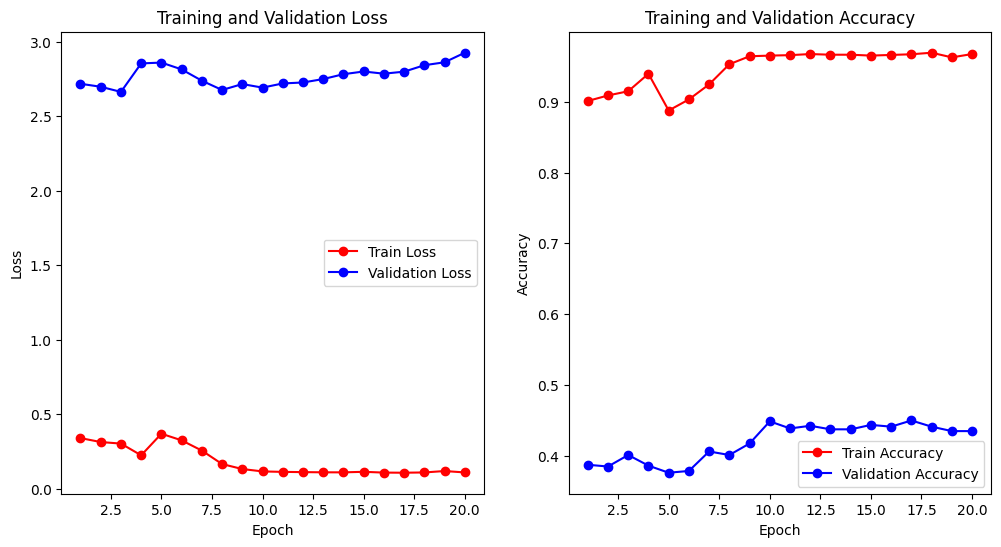

In [ ]:
train_loss=[]
train_accuracy=[]
val_loss=[]
val_accuracy=[]
# Updated GradScaler initialization as per FutureWarning
scaler = torch.amp.GradScaler('cuda')
best_val_accuracy = 0.0
NUM_EPOCHS=20 # Consider increasing NUM_EPOCHS for proper training

# Create a dynamic directory for checkpoints
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_dir = f"/content/drive/MyDrive/iNatSound/finetune_classification_checkpoints_{timestamp}"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(NUM_EPOCHS):
    epoch_train_loss, epoch_train_accuracy = train_one_epoch_finetune(classification_model, train_loader, optimizer, criterion, scaler, epoch, device)
    epoch_valid_loss, epoch_valid_accuracy = validate_one_epoch(classification_model, valid_loader, criterion, device)

    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)
    val_loss.append(epoch_valid_loss)
    val_accuracy.append(epoch_valid_accuracy)

    print(f"Epoch {epoch+1} | Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f} | Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_accuracy:.4f}")

    # Save checkpoint if current validation accuracy is the best
    if epoch_valid_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_valid_accuracy
        checkpoint_path = os.path.join(checkpoint_dir, f"finetune_model_best_accuracy_ep{epoch+1}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': classification_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_accuracy': best_val_accuracy,
            'loss': epoch_valid_loss,
        }, checkpoint_path)
        print(f"Saved best model checkpoint to {checkpoint_path} with accuracy {best_val_accuracy:.4f}")

epoch_range = np.arange(1, NUM_EPOCHS + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, train_loss, marker = 'o', color='r', label='Train Loss')
plt.plot(epoch_range, val_loss, marker = 'o', color='b', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_range, train_accuracy, marker = 'o', color='r', label='Train Accuracy')
plt.plot(epoch_range, val_accuracy, marker = 'o', color='b', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.optim as optim
import os

# Define the path to your best checkpoint
# Make sure to update this path to the actual best checkpoint you want to load
# For example, from the output of the previous training run, it was:
# "/content/drive/MyDrive/iNatSound/finetune_classification_checkpoints_20260111-223037/finetune_model_best_accuracy_ep10.pth"
checkpoint_path = "/content/drive/MyDrive/iNatSound/finetune_classification_checkpoints_20260111-211513/finetune_model_best_accuracy_ep10.pth" # <--- UPDATE THIS PATH

if os.path.exists(checkpoint_path):
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load model state dict
    classification_model.load_state_dict(checkpoint['model_state_dict'])

    # Load optimizer state dict
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # You can also restore other values like epoch or best_val_accuracy
    start_epoch = checkpoint['epoch'] + 1
    best_val_accuracy = checkpoint['best_val_accuracy']

    print(f"Checkpoint loaded successfully from {checkpoint_path}")
    print(f"Resuming from epoch {start_epoch} with best validation accuracy: {best_val_accuracy:.4f}")
else:
    print(f"Error: Checkpoint file not found at {checkpoint_path}")
    print("Please update `checkpoint_path` with the correct location of your checkpoint.")

Checkpoint loaded successfully from /content/drive/MyDrive/iNatSound/finetune_classification_checkpoints_20260111-211513/finetune_model_best_accuracy_ep10.pth
Resuming from epoch 10 with best validation accuracy: 0.1888


In [ ]:
train_loss=[]
train_accuracy=[]
val_loss=[]
val_accuracy=[]
scaler = torch.cuda.amp.GradScaler()
best_val_accuracy = 0.0

# Create a dynamic directory for checkpoints
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_dir = f"/content/drive/MyDrive/iNatSound/finetune_classification_checkpoints_{timestamp}"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(start_epoch,NUM_EPOCHS):
    epoch_train_loss, epoch_train_accuracy = train_one_epoch_finetune(classification_model, train_loader, optimizer, criterion, scaler, epoch, device)
    epoch_valid_loss, epoch_valid_accuracy = validate_one_epoch(classification_model, valid_loader, criterion, device)

    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)
    val_loss.append(epoch_valid_loss)
    val_accuracy.append(epoch_valid_accuracy)

    print(f"Epoch {epoch+1} | Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f} | Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_accuracy:.4f}")

    # Save checkpoint if current validation accuracy is the best
    if epoch_valid_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_valid_accuracy
        checkpoint_path = os.path.join(checkpoint_dir, f"finetune_model_best_accuracy_ep{epoch+1}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': classification_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_accuracy': best_val_accuracy,
            'loss': epoch_valid_loss,
        }, checkpoint_path)
        print(f"Saved best model checkpoint to {checkpoint_path} with accuracy {best_val_accuracy:.4f}")

epoch_range = np.arange(1, NUM_EPOCHS + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, train_loss, marker = 'ro',label='Train Loss')
plt.plot(epoch_range, val_loss, marker = 'bo',label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_range, train_accuracy, marker = 'ro',label='Train Accuracy')
plt.plot(epoch_range, val_accuracy, marker = 'bo',label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

/tmp/ipython-input-158729701.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 11, Batch 0/100 - Loss: 0.8462


KeyboardInterrupt: 